# MLP로 키포인트 벡터를 통한 실험

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# CSV 불러오기
df = pd.read_csv("labels.csv")

# keypoint 좌표만 추출 (x, y 총 34차원)
keypoint_cols = [col for col in df.columns if '_x' in col or '_y' in col]
X = df[keypoint_cols].values.astype('float32')

# visibility 0인 경우 좌표 0으로 마스킹된 상태여야 함
X = np.nan_to_num(X)

# 라벨 (0: good, 1: bad)
y = df['class_id'].astype(int).values

# 훈련/검증 세트 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 입력 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [5]:


model = Sequential([
    Dense(128, activation='relu', input_shape=(34,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)


NameError: name 'Sequential' is not defined

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       358
           1       0.74      0.63      0.68       225

    accuracy                           0.77       583
   macro avg       0.76      0.74      0.75       583
weighted avg       0.77      0.77      0.77       583



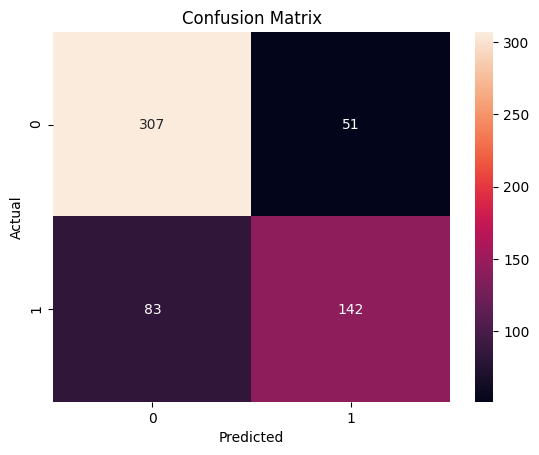

In [ ]:


# 예측
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# 평가 리포트
print(classification_report(y_val, y_pred))

# 혼동 행렬
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 하이퍼 파라미터 튜닝을 통한 실험

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch

# 모델 정의 함수
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(34,)))

    # Dense 레이어 수와 유닛 수 자동 설정
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=32),
                               activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [11]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mlp_tuning',
    project_name='posture_mlp'
)

early_stop = EarlyStopping(patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_val, y_val),
             callbacks=[early_stop, reduce_lr],
             verbose=2)

best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 14s]
val_accuracy: 0.7478559017181396

Best val_accuracy So Far: 0.7804459929466248
Total elapsed time: 00h 02m 40s
INFO:tensorflow:Oracle triggered exit


In [4]:
# TensorFlow 버전 확인
print("TensorFlow version:", tf.__version__)

# GPU 사용 가능 여부 확인
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.6.0
Num GPUs Available: 0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12029048795037568165
]


In [2]:
!nvidia-smi

Wed Jun 11 17:15:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8             11W /  140W |     850MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# MobileNetV2 기반 모델 학습 코드

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# CSV 불러오기
df = pd.read_csv("dataset-modification/train_pose_parsed.csv")
df_grouped = df.groupby("filename")["class_id"].min().reset_index()

# 필요한 컬럼만 사용
df = df[["filename", "class_id"]]

# # train/val 나누기
train_df, val_df = train_test_split(df, stratify=df["class_id"], test_size=0.2, random_state=42)
df["class_id"].value_counts()


0    1787
1    1124
Name: class_id, dtype: int64

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dir = "dataset-modification/train-visualized/images/"
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="filename",
    y_col="class_id",
    target_size=img_size,
    class_mode="raw",  # class_id가 숫자 그대로
    batch_size=batch_size
)

val_data = val_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col="filename",
    y_col="class_id",
    target_size=img_size,
    class_mode="raw",
    batch_size=batch_size
)


Found 2328 validated image filenames.
Found 583 validated image filenames.


In [3]:
duplicates = df["filename"].duplicated().sum()
print("중복된 이미지 파일 수:", duplicates)


중복된 이미지 파일 수: 330


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


              precision    recall  f1-score   support

         bad       0.63      0.64      0.63       358
        good       0.41      0.40      0.40       225

    accuracy                           0.55       583
   macro avg       0.52      0.52      0.52       583
weighted avg       0.54      0.55      0.54       583



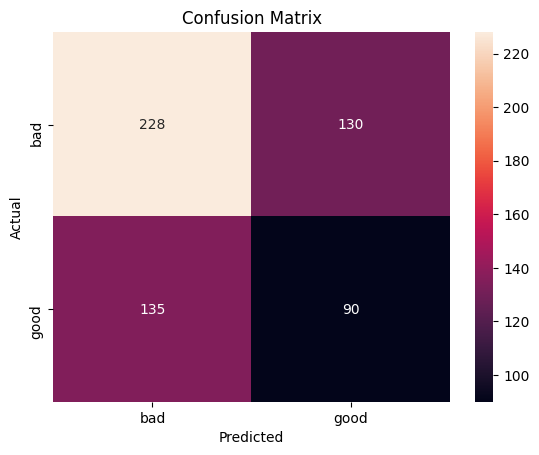

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 예측
y_true = val_data.labels
y_pred = model.predict(val_data)
y_pred_bin = (y_pred > 0.5).astype(int)

# 리포트 출력
print(classification_report(y_true, y_pred_bin, target_names=["bad", "good"]))

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["bad", "good"], yticklabels=["bad", "good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
